In [0]:
pip install -U imbalanced-learn

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-337cc897-4372-4347-8ed0-316402098bc6/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
pip freeze | grep imbalanced-learn

imbalanced-learn==0.8.1


In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext 
from pyspark.sql import SQLContext 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName('myproj').getOrCreate()
data = spark.read.csv('/FileStore/tables/train_data_011.csv',sep='|',inferSchema=True,header=True)
data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- uid: integer (nullable = true)
 |-- task_id: integer (nullable = true)
 |-- adv_id: integer (nullable = true)
 |-- creat_type_cd: integer (nullable = true)
 |-- adv_prim_id: integer (nullable = true)
 |-- dev_id: integer (nullable = true)
 |-- inter_type_cd: integer (nullable = true)
 |-- slot_id: integer (nullable = true)
 |-- spread_app_id: integer (nullable = true)
 |-- tags: integer (nullable = true)
 |-- app_first_class: integer (nullable = true)
 |-- app_second_class: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- city_rank: integer (nullable = true)
 |-- device_name: integer (nullable = true)
 |-- device_size: integer (nullable = true)
 |-- career: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- net_type: integer (nullable = true)
 |-- residence: integer (nullable = true)
 |-- his_app_size: integer (nullable = true)
 |-- his_on_shelf_time: integer (nulla

In [0]:
data=data.drop('communication_onlinerate')
data.show()

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+---------------------------+---------+----+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_avgonline_30d|indu_name|pt_d|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+--

In [0]:
type(data)

Out[4]: pyspark.sql.dataframe.DataFrame

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.functions import when, count, col
na_report=data.select([count(when(isnull(c), c)).alias(c) for c in data.columns])
print("Number of Rows: ",data.count() ,"   Number of Columns: ", len(data.columns))
na_report.show()

Number of Rows:  1000000    Number of Columns:  35
+-----+---+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+---------------------------+---------+----+
|label|uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_avgonline_30d|indu_name|pt_d|
+-----+---+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+--

In [0]:
df1=data.toPandas()

In [0]:
type(df1)

Out[7]: pandas.core.frame.DataFrame

In [0]:
#重采样
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)
oversampled_trainX,oversampled_trainY=sm.fit_resample(df1.drop('label', axis=1), df1['label'])

df2=pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [0]:
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df3 = sqlContext.createDataFrame(df2)

In [0]:
df3.select('age',  'city',  'city_rank',  'device_size', 
           'career','gender', 'net_type',  'app_score','label').describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|              city|         city_rank|       device_size|            career|            gender|          net_type|         app_score|             label|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|           1933200|           1933200|           1933200|           1933200|           1933200|           1933200|           1933200|           1933200|           1933200|
|   mean| 4.988112973308504|265.03405855576244|3.6606522863645767|158.48628698530933| 6.310086902545003| 2.371938754396855|2.1349943099524107|1.7646358369542727|               0.5|
| stddev|1.3390505585281485| 92.70483963302122|0.8384092586790781| 41.21655825968216|2.30467195

In [0]:
df3.printSchema()

root
 |-- label: integer (nullable = true)
 |-- uid: integer (nullable = true)
 |-- task_id: integer (nullable = true)
 |-- adv_id: integer (nullable = true)
 |-- creat_type_cd: integer (nullable = true)
 |-- adv_prim_id: integer (nullable = true)
 |-- dev_id: integer (nullable = true)
 |-- inter_type_cd: integer (nullable = true)
 |-- slot_id: integer (nullable = true)
 |-- spread_app_id: integer (nullable = true)
 |-- tags: integer (nullable = true)
 |-- app_first_class: integer (nullable = true)
 |-- app_second_class: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- city_rank: integer (nullable = true)
 |-- device_name: integer (nullable = true)
 |-- device_size: integer (nullable = true)
 |-- career: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- net_type: integer (nullable = true)
 |-- residence: integer (nullable = true)
 |-- his_app_size: integer (nullable = true)
 |-- his_on_shelf_time: integer (nulla

In [0]:
file = df3

Row(label=0, uid=1808686, task_id=3051, adv_id=5267, creat_type_cd=7, adv_prim_id=106, dev_id=57, inter_type_cd=4, slot_id=16, spread_app_id=38, tags=34, app_first_class=4, app_second_class=15, age=6, city=240, city_rank=5, device_name=91, device_size=310, career=3, gender=2, net_type=3, residence=35, his_app_size=10, his_on_shelf_time=2, app_score=2, emui_dev=27, list_time=14, device_price=5, up_life_duration=-1, up_membership_grade=-1, membership_life_duration=-1, consume_purchase=2, communication_avgonline_30d=11, indu_name=20, pt_d=2)
Number of training sets:200000
[1808686.0,3051.0,5267.0,7.0,106.0,57.0,4.0,16.0,38.0]
Predictive value:0,actual value0.0
Number of test sets:200000
The overall forecast accuracy rate is0.96688
PRvalue:0.0331,AUCvalue:0.5000
--------%%%% [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

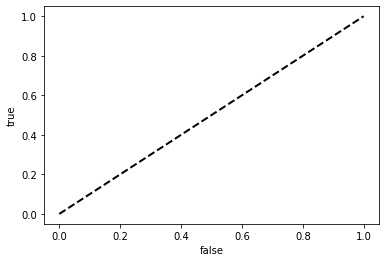

In [0]:
######svm
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local").appName("test").getOrCreate()
sc = spark.sparkContext
from pyspark.sql.types import *
from pyspark.mllib.classification import SVMModel
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col,expr,when 
 
#1. Train the model
#1.1 Read the data and construct the training data set

file.createOrReplaceTempView("file")
data = spark.sql("""select * from file limit 200000""").rdd.collect()
print(data[0]) 
# # You need to serialize row by row RDD data, and then construct LabeledPoint type labels and features
trainData = sc.parallelize(data).map(lambda x:LabeledPoint(label=x[0],features=x[1:10]))
# trainData.take(2)
print("Number of training sets:{}".format(trainData.count()))
print(trainData.first().features)
 
#1.2 Training model
svm = SVMWithSGD.train(sc.parallelize(trainData.collect()), iterations=10)
 
prediction = svm.predict(trainData.first().features)
print("Predictive value:{},actual value{}".format(prediction,trainData.first().label))
# #2. Evaluate the effect of model training
# #2.1 Constructing a test data set
data2 = spark.sql("""select * from file limit 200000""").rdd.collect()
testData = sc.parallelize(data2).map(lambda x:LabeledPoint(label=x[0],features=x[1:10]))
print("Number of test sets:{}".format(testData.count()))
 
# #2. Classification effect evaluation
# #Overall forecast accuracy
svmTotalCorrect = testData.map(lambda x: 1 if svm.predict(x.features) == x.label else 0).sum()
#print("Classification accuracy:{}".format(svmTotalCorrect))
svmAccuracy = float(svmTotalCorrect)/testData.count()
print("The overall forecast accuracy rate is{}".format(svmAccuracy))
 
# # #Calculate AUC
scoreAndLabels = testData.map(lambda x:(float(svm.predict(x.features)),x.label))
metrics = BinaryClassificationMetrics(scoreAndLabels)
print('PRvalue:{:.4f},AUCvalue:{:.4f}'.format(metrics.areaUnderPR,metrics.areaUnderROC))


###Drawing ROC
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Get the true value
trainlist=[]
for index in range(50):
    trainlist.append(testData.collect()[index].label)
print("--------%%%%",trainlist)
y_label=(trainlist)
###Get the predicted value
prelist=[]
for index in range(50):
    prelist.append(svm.predict(testData.collect()[index].features))
y_pre=(prelist)
print("---y_pre--",y_pre)
fpr,tpr,thersholds=roc_curve(y_label,y_pre)

plt.plot(fpr,tpr,"k--",label="ROC",lw=2)
plt.xlabel("false")
plt.ylabel("true")  
plt.title="roc"
plt.show()


In [0]:
###Logistic regression
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
#1.Get training model data
file.createOrReplaceTempView("file")
data = spark.sql("""select * from file limit 200000""").rdd.collect()
print(data[0]) 
trainData = sc.parallelize(data).map(lambda x:LabeledPoint(label=x[0],features=x[1:10]))
# trainData.take(2)
print("Number of training sets:{}".format(trainData.count()))
print(trainData.first().features)
 #2 Logistic regression training model
svm = LogisticRegressionWithSGD.train(sc.parallelize(trainData.collect()), iterations=3)
prediction = svm.predict(trainData.first().features)
print("Predictive value:{},actual value{}".format(prediction,trainData.first().label))
 
#2.Evaluate the training effect of logistic regression model
# 2Construct a test data set
data2 = spark.sql("""select * from file  limit 100000""").rdd.collect()
testData = sc.parallelize(data2).map(lambda x:LabeledPoint(label=x[0],features=x[1:10]))
print("Number of test sets:{}".format(testData.count()))
 
# 2.2 Classification effect evaluation
# Overall logistic regression prediction accuracy
svmTotalCorrect = testData.map(lambda x: 1 if svm.predict(x.features) == x.label else 0).sum()
#print("Classification accuracy:{}".format(svmTotalCorrect))
svmAccuracy = float(svmTotalCorrect)/testData.count()
print("The overall forecast accuracy rate is{}".format(svmAccuracy))
 
# # #AUC计算
scoreAndLabels = testData.map(lambda x:(float(svm.predict(x.features)),x.label))
metrics = BinaryClassificationMetrics(scoreAndLabels)
print('PRvalue:{:.4f},AUCvalue:{:.4f}'.format(metrics.areaUnderPR,metrics.areaUnderROC))




Row(label=0, uid=1808686, task_id=3051, adv_id=5267, creat_type_cd=7, adv_prim_id=106, dev_id=57, inter_type_cd=4, slot_id=16, spread_app_id=38, tags=34, app_first_class=4, app_second_class=15, age=6, city=240, city_rank=5, device_name=91, device_size=310, career=3, gender=2, net_type=3, residence=35, his_app_size=10, his_on_shelf_time=2, app_score=2, emui_dev=27, list_time=14, device_price=5, up_life_duration=-1, up_membership_grade=-1, membership_life_duration=-1, consume_purchase=2, communication_avgonline_30d=11, indu_name=20, pt_d=2)
Number of training sets:200000
[1808686.0,3051.0,5267.0,7.0,106.0,57.0,4.0,16.0,38.0]
Predictive value:0,actual value0.0
Number of test sets:100000
The overall forecast accuracy rate is0.96669
PRvalue:0.0333,AUCvalue:0.5000


In [0]:
###Select the columns involved in the calculation
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=[
     'indu_name',
     'his_on_shelf_time',
     'app_first_class',
     'his_app_size',
     'age',
    'app_score',
    "device_price",
 ], outputCol='features')
 
assembled_data=assemble.transform(file)
 
assembled_data.show(2)
assembled_data.select('features').show()

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+---------------------------+---------+----+--------------------+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_avgonline_30d|indu_name|pt_d|            features|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---

Row(label=0, uid=1000022, task_id=2707, adv_id=4150, creat_type_cd=7, adv_prim_id=133, dev_id=37, inter_type_cd=5, slot_id=12, spread_app_id=34, tags=13, app_first_class=4, app_second_class=25, age=6, city=149, city_rank=5, device_name=88, device_size=180, career=9, gender=2, net_type=2, residence=14, his_app_size=17, his_on_shelf_time=3, app_score=2, emui_dev=20, list_time=7, device_price=3, up_life_duration=20, up_membership_grade=-1, membership_life_duration=-1, consume_purchase=2, communication_avgonline_30d=13, indu_name=17, pt_d=4) <class 'pyspark.sql.dataframe.DataFrame'> DataFrame[label: int, uid: int, task_id: int, adv_id: int, creat_type_cd: int, adv_prim_id: int, dev_id: int, inter_type_cd: int, slot_id: int, spread_app_id: int, tags: int, app_first_class: int, app_second_class: int, age: int, city: int, city_rank: int, device_name: int, device_size: int, career: int, gender: int, net_type: int, residence: int, his_app_size: int, his_on_shelf_time: int, app_score: int, emui_

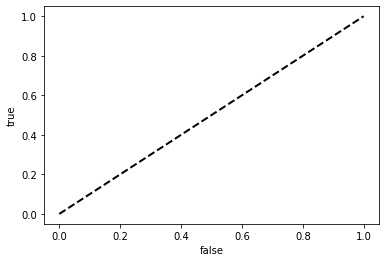

In [0]:
#Random forest
from pyspark.sql import SparkSession
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import IntegerType


# Set the maximum number of categories, those less than or equal to n are category features, and those greater than n are continuous features
featureIndexer = VectorIndexer().setInputCol("features").setOutputCol("indexedFeatures").setMaxCategories(24)
# Randomly divide the data1 data set, this data is used in the decision model
trainingData, testData = file.randomSplit([0.7, 0.3])
print(trainingData.head(),type(trainingData),trainingData)

# Set the decision tree regression model
# MaxBins: the maximum number of discretization of continuous features
dt = DecisionTreeRegressor().setLabelCol("label").setFeaturesCol("indexedFeatures").setMaxBins(64)

#Assemble the feature conversion and model training involved in the decision tree regression model on an assembly line.
pipeline = Pipeline().setStages([assemble,featureIndexer, dt])


model = pipeline.fit(trainingData)
# Predict the value of the decision tree regression
predictions = model.transform(testData)


predictions.createOrReplaceTempView("temp")
pre= spark.sql("""select *, case when prediction <= %s then 0
                                when prediction > %s then 1
                                else 3 end as predictions
                        from temp limit 100"""%(0.1,0.1))
pre.select("*").show(2) 
#2.3 Evaluate the effectiveness of classification
total_amount=pre.count()
print("-----total_amount--",total_amount)
correct_amount = pre.filter(pre.label==pre.predictions).count()
# print("--correct_amount--",correct_amount)
precision_rate = correct_amount/total_amount
print("The prediction accuracy of the decision tree algorithm module is:{}".format(precision_rate))

print("------pre.label---",pre.collect()[0].label)
print("------pre.predictions---",pre.collect()[0].predictions)

######ROC
labellist=[]
for index in range(100):
    labellist.append(pre.collect()[index].label)
y_label=(labellist)    
print("---y_label---",y_label)  
print("---labellist---",labellist)
prelist=[]
for index in range(100):
    prelist.append(pre.collect()[index].predictions)
    
y_pre=(prelist)
print("---prelist---",prelist)
print("---y_pre--",y_pre)
fpr,tpr,thersholds=roc_curve(y_pre,y_label)

plt.plot(fpr,tpr,"k--",label="ROC",lw=2)
plt.xlabel("false")
plt.ylabel("true")  
plt.title="roc"
plt.show()

In [0]:
file =df3.select(col("label"),col("uid"),col("city_rank"),col("communication_avgonline_30d"),col("app_score"),col("age"),col("career"),col("gender"),col("device_price"),col("net_type"))